## **KNN Algorithm Implementation Notebook ('KNN.ipynb')**

This notebook describes the implementation of the K-Nearest Neighbors (KNN) algorithm using the `sklearn` library in Python. The primary objective is to accurately predict class labels— **Positive**, **Neutral**, or **Negative** — based on facial expression images. We trained the models using our dataset of self-taken webcam images. We focused on optimizing the `n_neighbors` parameter (commonly known as 'k') to improve the model's accuracy, with the best accuracy on the training and testing datasets detailed in the final report.

---

#### **Workflow Summary**

1. **Import all necessary libraries for the KNN algorithm.**

2. **Dataset Handling**
   - *Load Dataset:* Self-Taken Webcam Images
   - *Train-Validation Split:* Split the dataset into training and validation subsets (80:20 ratio)

3. **Baseline KNN Model**
   - *Initial Model Training:* Train the baseline KNN model with a default *k* = 3

4. **Optimization of \( k \)**
   - *Hyperparameter Tuning:* Experiment with different values of *k* to find the optimal setting
   - Plot of Error vs. Increasing Values of *k* 
   - Cross Validation

5. **Model Re-evaluation**
   - *Retrain with Optimal k:* Rerun the KNN model using the identified optimal *k*

6. **Model Evaluation**
   - *Performance Metrics:* Evaluate the model’s accuracy on both the training and validation datasets

7. **Enhanced Model with Preprocessing**
   - *Integrate Face Cropping:* Incorporate a preprocessing step of face cropping using a pre-trained YOLOv8 model, then repeat training and evaluation


**🔎 Note:** A seed value of 42 is consistently used throughout the implementations to ensure reproducibility of the results.


#### Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

from ultralytics import YOLO
from PIL import Image

2024-04-20 22:32:38.059035: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Loading Images and Train-Validation Split

In [2]:
train = keras.utils.image_dataset_from_directory(
    directory='../../data/Webcam Images',
    labels='inferred',
    label_mode='categorical',
    batch_size=140,
    image_size=(1000, 1000),
    validation_split = 0.2,
    subset = 'training',
    seed = 42,
    )

validation = keras.utils.image_dataset_from_directory(
    directory='../../data/Webcam Images',
    labels='inferred',
    label_mode='categorical',
    batch_size=140,
    image_size=(1000, 1000),
    validation_split = 0.2,
    subset = 'validation',
    seed = 42,
    )

Found 164 files belonging to 3 classes.


Using 132 files for training.
Found 164 files belonging to 3 classes.
Using 32 files for validation.


In [214]:
#convert to numpy images and then perform PCA to extract the values
#convert images to numpy
train_processed_numpy = train.as_numpy_iterator()
validation_processed_numpy = validation.as_numpy_iterator()

X_train, y_train = train_processed_numpy.next()
X_val, y_val = validation_processed_numpy.next()

In [215]:
print(X_train.shape, '\n', X_val.shape, '\n', y_train.shape, '\n', y_val.shape)

(132, 1000, 1000, 3) 
 (32, 1000, 1000, 3) 
 (132, 3) 
 (32, 3)


In [216]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3]))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1] * X_val.shape[2] * X_val.shape[3]))

PCA

In [217]:
pca = PCA(n_components=80) # adjust later
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val) # reduce bias by just using the scaling done on training data on the testing data

print("Shape of PCA-transformed data:", X_train_pca.shape) # (n_samples, 50)

print("Number of components used:", pca.n_components_)

# explained variance ratio
print("Explained variance ratio per component:", pca.explained_variance_ratio_)
print("Sum of explained variance ratio:", np.sum(pca.explained_variance_ratio_))


Shape of PCA-transformed data: (132, 80)
Number of components used: 80
Explained variance ratio per component: [    0.20651     0.14495     0.10456    0.067417    0.057138    0.033978    0.030652    0.026437    0.020612    0.019559    0.016246    0.015424    0.014138    0.012764    0.011161    0.010707    0.009812   0.0089151   0.0084196   0.0076068   0.0071407   0.0068877   0.0066482    0.006417   0.0060365   0.0056977
   0.0053482   0.0051207   0.0049632   0.0047656   0.0043856   0.0042896   0.0041496   0.0039296   0.0038533   0.0035089   0.0034772   0.0032123   0.0030234    0.002913   0.0028567   0.0027227   0.0025163   0.0023896   0.0023494   0.0022089   0.0021718   0.0021159   0.0020111   0.0019308    0.001851   0.0017953
   0.0017806   0.0017015   0.0016678   0.0015718   0.0015365   0.0015218   0.0014716   0.0013593   0.0013413   0.0013136   0.0012775   0.0012234   0.0012049   0.0011431   0.0011149   0.0010866    0.001069   0.0010117  0.00099592  0.00098863  0.00094852  0.0009100

In [218]:
knn_model = KNeighborsClassifier(n_neighbors=3) # adjust later using elbow
knn_model.fit(X_train_pca, np.argmax(y_train, axis = 1))

KNeighborsClassifier(n_neighbors=3)

In [219]:
y_train_pred = knn_model.predict(X_train_pca)
y_val_pred = knn_model.predict(X_val_pca)

In [220]:
print("Train Accuracy:", accuracy_score(np.argmax(y_train, axis=1), y_train_pred))
print("Test Accuracy:", accuracy_score(np.argmax(y_val, axis=1), y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(np.argmax(y_val, axis=1), y_val_pred))
print("Classification Report:\n", classification_report(np.argmax(y_val, axis=1), y_val_pred))

Train Accuracy: 0.8787878787878788
Test Accuracy: 0.6875
Confusion Matrix:
 [[4 1 2]
 [0 9 6]
 [1 0 9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.90      0.60      0.72        15
           2       0.53      0.90      0.67        10

    accuracy                           0.69        32
   macro avg       0.74      0.69      0.68        32
weighted avg       0.76      0.69      0.69        32



#### finding optimal k for KNN
from the charts below, we can see that through plotting the error/accuracy against k and using cross validation to find the k which givest the highest validation accuracy score, both give k = 1. hence we will use this.

optimal K = 1 with validation accuracy of 0.75


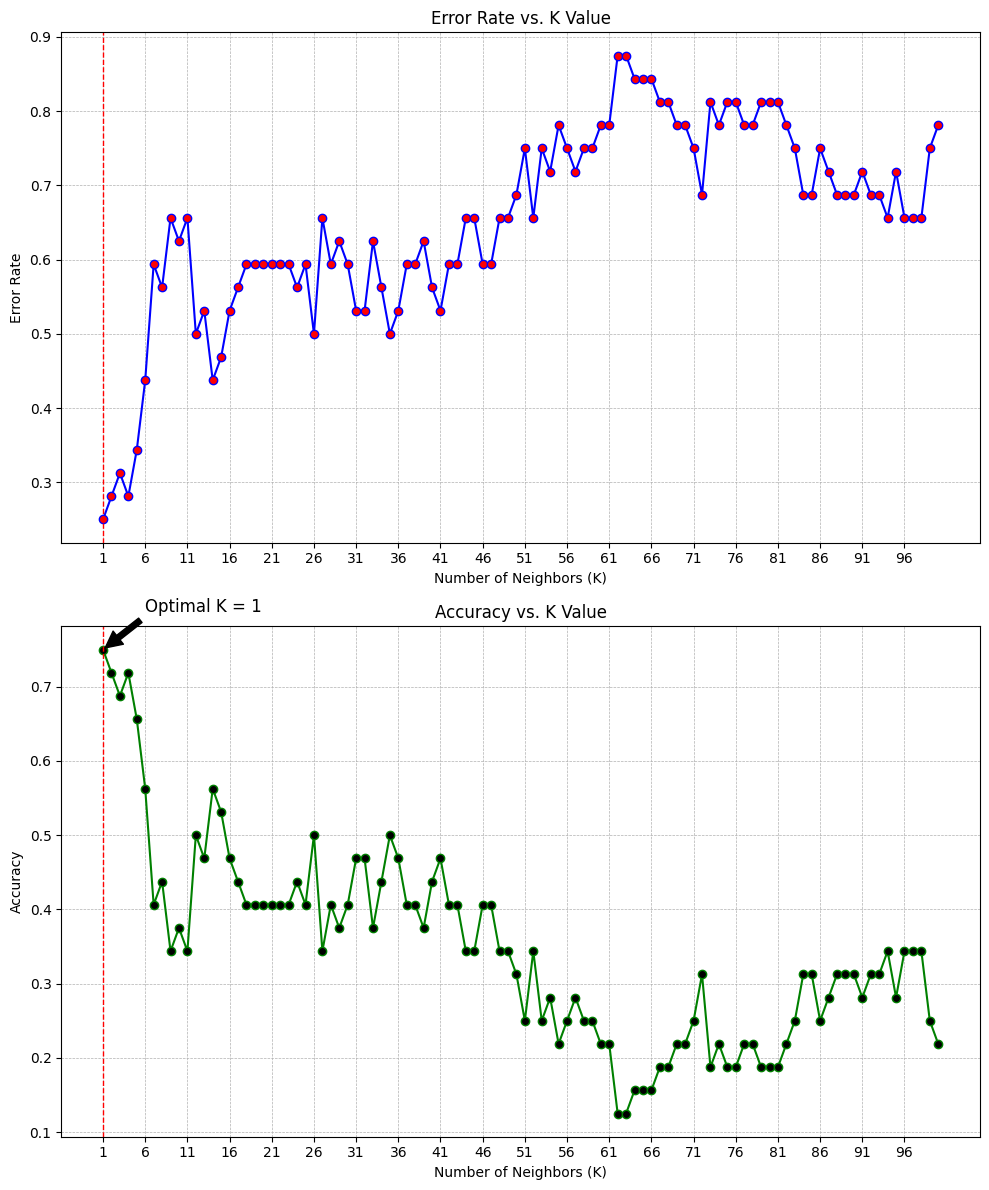

In [221]:
error_rates = []
accuracy_list = []

for i in range(1, 101):  # checking k from 1 to 100
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_pca, np.argmax(y_train, axis=1))
    y_pred = knn.predict(X_val_pca)  
    error_rates.append(np.mean(y_pred != np.argmax(y_val, axis=1)))
    accuracy_list.append(accuracy_score(np.argmax(y_val, axis=1), y_pred))


optimal_k = max(range(len(accuracy_list)), key=accuracy_list.__getitem__) + 1 
print('optimal K =', optimal_k, 'with validation accuracy of', max(accuracy_list))

plt.figure(figsize=(10, 12))

# Error rate plot
plt.subplot(2, 1, 1)
plt.plot(range(1, 101), error_rates, color='blue', linestyle='-', marker='o', markerfacecolor='red')
plt.axvline(x=optimal_k, color='red', linestyle='--', linewidth=1)
plt.title('Error Rate vs. K Value')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Error Rate')
plt.xticks(np.arange(1, 101, 5))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Accuracy plot
plt.subplot(2, 1, 2)
plt.plot(range(1, 101), accuracy_list, color='green', linestyle='-', marker='o', markerfacecolor='black')
plt.axvline(x=optimal_k, color='red', linestyle='--', linewidth=1)
plt.annotate(f'Optimal K = {optimal_k}', xy=(optimal_k, max(accuracy_list)), xytext=(optimal_k+5, 0.8),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)
plt.title('Accuracy vs. K Value')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 101, 5))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()



In [222]:
y_train_labels = np.argmax(y_train, axis=1)

knn_cv = KNeighborsClassifier()

param_grid = {'n_neighbors': range(1, 101)}  # check from 1 to 40 neighbors

grid_search = GridSearchCV(knn_cv, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train_labels)

print("Best number of neighbors:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best number of neighbors: {'n_neighbors': 1}
Best cross-validation score: 0.74


##### trying with optimal k found above, k = 1

In [223]:
knn_model_optimal_k = KNeighborsClassifier(n_neighbors=1) 
knn_model_optimal_k.fit(X_train_pca, np.argmax(y_train, axis = 1))

y_train_pred = knn_model_optimal_k.predict(X_train_pca)
y_val_pred = knn_model_optimal_k.predict(X_val_pca)

print("Train Accuracy:", accuracy_score(np.argmax(y_train, axis=1), y_train_pred))
print("Test Accuracy:", accuracy_score(np.argmax(y_val, axis=1), y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(np.argmax(y_val, axis=1), y_val_pred))
print("Classification Report:\n", classification_report(np.argmax(y_val, axis=1), y_val_pred))

Train Accuracy: 1.0
Test Accuracy: 0.75
Confusion Matrix:
 [[6 0 1]
 [0 9 6]
 [1 0 9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       1.00      0.60      0.75        15
           2       0.56      0.90      0.69        10

    accuracy                           0.75        32
   macro avg       0.81      0.79      0.77        32
weighted avg       0.83      0.75      0.76        32



#### with face cropping

In [224]:
#convert to numpy images and then perform PCA to extract the values
#convert images to numpy
train_processed_numpy = train.as_numpy_iterator()
validation_processed_numpy = validation.as_numpy_iterator()

X_train, y_train = train_processed_numpy.next()
X_val, y_val = validation_processed_numpy.next()

using pre-trained YoloV8 model to crop our original webcam images

In [225]:
#convert the images to cropped faces
face_classifier = YOLO("../../app/src/face_detection/model/yolov8n-face.pt")

X_cropped_train = []
y_train_cropped = []

n_train = X_train.shape[0]
for i in range(n_train):
    face = X_train[i]
   
    faces = face_classifier.predict(face)
    boxes = faces[0].boxes.xyxy.tolist()
    if boxes:
        
        #extract the face based on the output from the YOLOv8 model        
        left, bottom, right, top = boxes[0]
        cropped_face = face[int(bottom):int(top), int(left):int(right)]
        #resize cropped face to a std shape, 100x100 for now but can adjust this
        pil_face = Image.fromarray(np.uint8(cropped_face))
        pil_face = pil_face.resize((200, 200))
        numpy_cropped_face = np.array(pil_face)
        #append this to the new list containing all cropped faces
        X_cropped_train.append(numpy_cropped_face)
        y_train_cropped.append(y_train[i])

X_val_cropped = []
y_val_cropped = []
n_val = X_val.shape[0]

for i in range(n_val):
    face = X_val[i]
    faces = face_classifier.predict(face)
    boxes = faces[0].boxes.xyxy.tolist()
    if boxes:
        
        #extract the face based on the output from the YOLOv8 model        
        left, bottom, right, top = boxes[0]
        cropped_face = face[int(bottom):int(top), int(left):int(right)]
        #resize cropped face to a std shape, 100x100 for now but can adjust this
        pil_face = Image.fromarray(np.uint8(cropped_face))
        pil_face = pil_face.resize((200, 200))
        numpy_cropped_face = np.array(pil_face)
        #append this to the new list containing all cropped faces
        X_val_cropped.append(numpy_cropped_face)
        y_val_cropped.append(y_val[i])



0: 640x640 1 face, 215.2ms
Speed: 14.6ms preprocess, 215.2ms inference, 8.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 176.7ms
Speed: 7.5ms preprocess, 176.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 179.6ms
Speed: 6.4ms preprocess, 179.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 180.6ms
Speed: 8.5ms preprocess, 180.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 194.6ms
Speed: 7.1ms preprocess, 194.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 190.3ms
Speed: 7.8ms preprocess, 190.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 207.7ms
Speed: 8.8ms preprocess, 207.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 202.5ms
Speed: 6.8ms preprocess, 202.5ms inference, 0.8ms postprocess per image at shape

In [226]:
#change the variables to numpy arrays
X_cropped_train = np.array(X_cropped_train)

X_val_cropped = np.array(X_val_cropped)

print(X_cropped_train.shape)
print(X_val_cropped.shape)

#Flatten the RGB image into a flat tensor
X_cropped_train = X_cropped_train.reshape((X_cropped_train.shape[0], X_cropped_train.shape[1] * X_cropped_train.shape[2] * X_cropped_train.shape[3]))
X_val_cropped = X_val_cropped.reshape((X_val_cropped.shape[0], X_val_cropped.shape[1] * X_val_cropped.shape[2] * X_val_cropped.shape[3]))

(121, 200, 200, 3)
(28, 200, 200, 3)


In [227]:
y_train_lab = np.array(y_train_cropped).argmax(axis = 1)
y_val_lab = np.array(y_val_cropped).argmax(axis = 1)

In [228]:
pca = PCA(n_components = 50)

X_cropped_train_lower_dim = pca.fit_transform(X_cropped_train)
X_cropped_val_lower_dim = pca.transform(X_val_cropped)

In [229]:
knn_cropped = KNeighborsClassifier(n_neighbors=3)
knn_cropped.fit(X_cropped_train_lower_dim, y_train_lab)

KNeighborsClassifier(n_neighbors=3)

In [231]:
y_train_pred = knn_cropped.predict(X_cropped_train_lower_dim)
y_val_pred = knn_cropped.predict(X_cropped_val_lower_dim)

print("Train Accuracy:", accuracy_score(y_train_lab, y_train_pred))
print("Test Accuracy:", accuracy_score(y_val_lab, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val_lab, y_val_pred))
print("Classification Report:\n", classification_report(y_val_lab, y_val_pred))

Train Accuracy: 0.8347107438016529
Test Accuracy: 0.6071428571428571
Confusion Matrix:
 [[4 0 2]
 [3 6 4]
 [0 2 7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       0.75      0.46      0.57        13
           2       0.54      0.78      0.64         9

    accuracy                           0.61        28
   macro avg       0.62      0.64      0.61        28
weighted avg       0.64      0.61      0.60        28



finding optimal k

In [235]:
knn_cv = KNeighborsClassifier()

param_grid = {'n_neighbors': range(1, 101)}  # check from 1 to 40 neighbors

grid_search = GridSearchCV(knn_cv, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_cropped_train_lower_dim, y_train_lab)

print("Best number of neighbors:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best number of neighbors: {'n_neighbors': 1}
Best cross-validation score: 0.62


/Users/saxyrinchen/.pyenv/versions/3.8.11/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saxyrinchen/.pyenv/versions/3.8.11/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/saxyrinchen/.pyenv/versions/3.8.11/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/saxyrinchen/.pyenv/versions/3.8.11/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/saxyrinchen/.pyenv/versions/3.8.11/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_

using optimal k = 1 for KNN model after face crop
- improved train and test accuracy

In [237]:
knn_cropped = KNeighborsClassifier(n_neighbors=1)
knn_cropped.fit(X_cropped_train_lower_dim, y_train_lab)

y_train_pred = knn_cropped.predict(X_cropped_train_lower_dim)
y_val_pred = knn_cropped.predict(X_cropped_val_lower_dim)

print("Train Accuracy:", accuracy_score(y_train_lab, y_train_pred))
print("Test Accuracy:", accuracy_score(y_val_lab, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val_lab, y_val_pred))
print("Classification Report:\n", classification_report(y_val_lab, y_val_pred))


Train Accuracy: 1.0
Test Accuracy: 0.6785714285714286
Confusion Matrix:
 [[4 0 2]
 [1 9 3]
 [0 3 6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.75      0.69      0.72        13
           2       0.55      0.67      0.60         9

    accuracy                           0.68        28
   macro avg       0.70      0.68      0.68        28
weighted avg       0.69      0.68      0.68        28

